**Mounting colab notebook to Drive**

In [ ]:
# Mounting colab notebook to drive
from google.colab import drive
drive.mount('/content/drive')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Julia installation (run once)**

In [ ]:
# Julia installation
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

*Installing PySR and relevant packages*

In [ ]:
# Installing PySR (and relevant packages)
!pip install pysr

*Importing relevant modules*

In [ ]:
#Importing relevant modules
import os
import matplotlib as plt
import pandas as pd
import numpy as np
from pysr import pysr, best, PySRRegressor

*Verifying working directory*

In [ ]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/Symbolic-Regressor/Feynman Local


*Function Deposit (run once)*

In [ ]:
# Function deposit
def get_y_values(x_values):
  y_values = -0.5 * x_values[:, 0] + 0.5 * x_values[:, 1] + 3
  return y_values

def get_noisy_y_values(x_values):
  noisy_y_values = -0.5 * x_values[:, 0] + 0.5 * x_values[:, 2] + 3
  return noisy_y_values

*Perfect data - generation, plotting, symbolic regression*

In [ ]:
#Generating data sets compatible with PySR wagwarn bot dat dign
np.random.seed(2)
x_values = np.random.randn(10000, 2)

y_values = get_y_values(x_values)

np.save('x_values_pysr.npy',x_values)
np.savetxt('x_values_pysr.txt',x_values,delimiter=' ')

np.save('y_values_pysr.npy',y_values)
np.savetxt('y_values_pysr.txt',y_values,delimiter=' ')

# Converting data into a .txt format compatible with matplotlib (for plotting step)
with open('xy_data_pysr.txt', 'w') as f:
  for r in range(10000):
    f.write(f'{x_values[:, 0][r]} {x_values[:, 1][r]} {y_values[r]}\n')

<ipython-input-40-4ec051471541>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


             0         1         2
0    -0.416758 -0.056267  3.180246
1    -2.136196  1.640271  4.888233
2    -1.793436 -0.841747  3.475844
3     0.502881 -1.245288  2.125915
4    -1.057952 -0.909008  3.074472
...        ...       ...       ...
9995 -1.005904  1.564422  4.285163
9996 -0.663491  0.857396  3.760444
9997  1.289236  0.941803  2.826283
9998  0.220196  0.142931  2.961368
9999 -0.036667  0.617264  3.326965

[10000 rows x 3 columns]


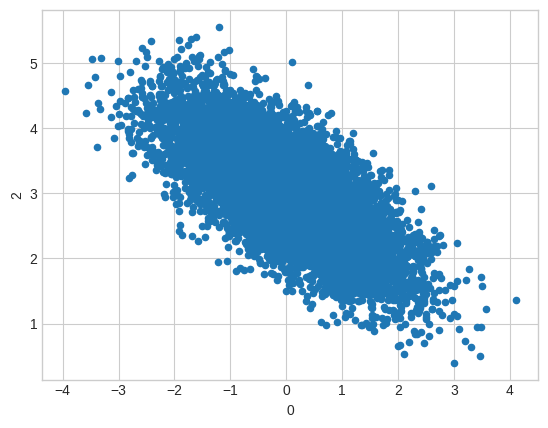

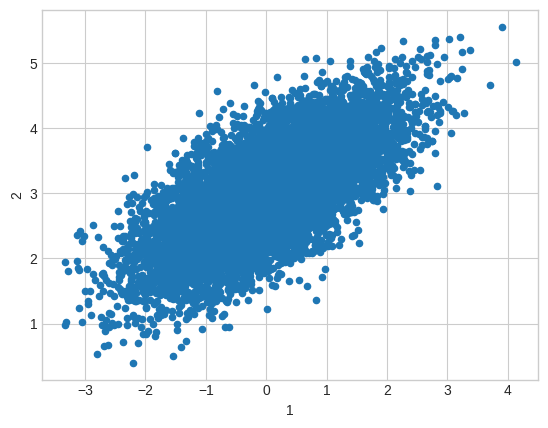

In [ ]:
# Printing perfect data with Pandas and plotting it with matplotlib
plt.style.use('seaborn-whitegrid')
df=pd.read_csv(input_path + 'xy_data_pysr.txt',sep=" ",header=None)
df.plot.scatter(x=0, y=2)
df.plot.scatter(x=1, y=2)
print(df)

In [ ]:
# Running PySR symbolic regression on perfect data (OLD Implementation for reference)

# equations = pysr(
#     x_values,
#     y_values,
#     niterations=5,
#     binary_operators=["+", "*", "-", "/"],
#     unary_operators=[
#         "sign",
#         "neg",
#         "cos",
#         "exp",
#         "sin",  # Pre-defined library of operators (see docs)
#         #"inv(x) = 1/x",  # Define your own operator! (Julia syntax)
#     ],
#     extra_sympy_mappings={'inv': lambda x: 1/x},
# )

# ...# (you can use ctl-c to exit early)

# print(best(equations))

In [ ]:
for num_iters in [10]: #, 30, 60, 80, 100 #for loop for hyperparameter tuning
    model = PySRRegressor(
        niterations=num_iters,  # < Increase me for better results
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "sign",
            "neg",
            "cos",
            "exp",
            "sin",  # Pre-defined library of operators (see docs)
            "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        # ^ Custom loss function (julia syntax)
    )

    print(model.fit(x_values, y_values))
    #for saving the model
    # model_path = input_path + 'data/model-%2d.pkl'%(num_iters)

    # with open(model_path, 'wb') as file:
    #   pickle.dump(model, file)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 150 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.670e+03
Head worker occupation: 5.9%
Progress: 9 / 150 total iterations (6.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           5.229e-01  7.971e+00  y = exp(1.0448)
3           4.988e-01  4.735e-02  y = exp(exp(0.084269))
5           3.612e-01  1.613e-01  y = exp(1.0448) + sin(x₁)
7           3.553e-01  8.249e-03  y = exp(1.0448) + sin(0.034001 + x₁)
8           2.018e-01  5.658e-01  y = exp(exp(sin(0.084269 * (

In [ ]:
print(model.sympy()) #get best fit expression

(-x0 + x1)*0.5 - 1*(-3.0)


*Introducing noise (and unwanted variables) into the data - generation, plotting, symbolic regression*

In [ ]:
#Generating noisy data sets compatible with PySR
np.random.seed(2)
x_values = np.random.randn(10000, 4)

noisy_y_values = get_noisy_y_values(x_values)

mu = 0
sigma = 0.05
noise = np.random.normal(mu, sigma, 4)
noisy_x_values = x_values + noise

np.save('noisy_x_values_pysr.npy',noisy_x_values)
np.savetxt('noisy_x_values_pysr.txt',noisy_x_values,delimiter=' ')

np.save('noisy_y_values_pysr.npy',noisy_y_values)
np.savetxt('noisy_y_values_pysr.txt',noisy_y_values,delimiter=' ')

# Converting data into a .txt format compatible with matplotlib (for plotting step)
with open('xy_noisy_data_pysr.txt', 'w') as f:
  for r in range(10000):
    f.write(f'{x_values[:, 0][r]} {x_values[:, 2][r]} {y_values[r]}\n')

<ipython-input-35-a28ca760e679>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


             0         1         2
0    -0.416758 -2.136196  1.881949
1    -1.793436  0.502881  2.727602
2    -1.057952  0.551454  1.416527
3     0.041539  0.539058  1.746991
4    -0.019130 -0.747871  2.715795
...        ...       ...       ...
9995 -0.034001 -1.669722  2.398629
9996  1.535821  0.959539  3.351342
9997  0.843201  0.579179  1.973611
9998 -0.531077 -0.150095  3.813109
9999 -0.497091 -0.434859  2.508809

[10000 rows x 3 columns]


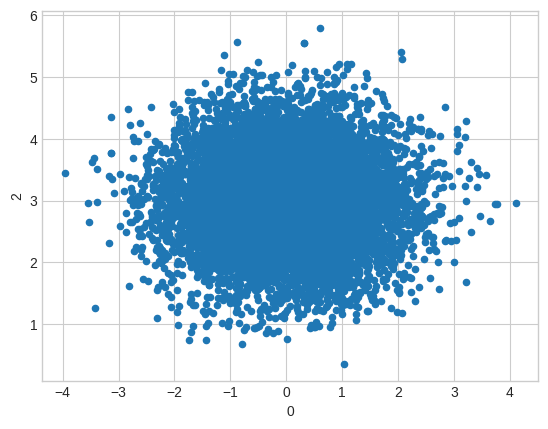

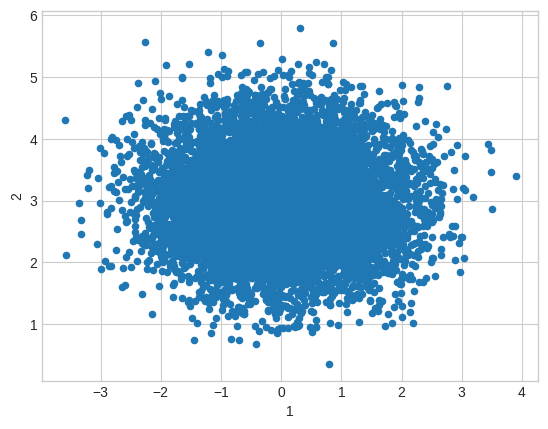

In [ ]:
# Printing perfect data with Pandas and plotting it with matplotlib
plt.style.use('seaborn-whitegrid')
df=pd.read_csv(input_path + 'xy_noisy_data_pysr.txt',sep=" ",header=None)
df.plot.scatter(x=0, y=2)
df.plot.scatter(x=1, y=2)
print(df)

In [ ]:
# Running PySR symbolic regression on the noisy data
# equations = pysr(
#     noisy_x_values,
#     y_values, #normal_y_values?
#     niterations=5,
#     binary_operators=["+", "*", "-", "/"],
#     unary_operators=[
#         "sign",
#         "neg",
#         "cos",
#         "exp",
#         "sin",  # Pre-defined library of operators (see docs)
#         "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
#     ],
# )

for num_iters in [10]: #, 30, 60, 80
    model = PySRRegressor(
        niterations=num_iters,  # < Increase me for better results
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "sign",
            "neg",
            "cos",
            "exp",
            "sin",  # Pre-defined library of operators (see docs)
            "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        # ^ Custom loss function (julia syntax)
    )

    model.fit(noisy_x_values, y_values)

    model_path = input_path + 'data/noisemodel-%2d.pkl'%(num_iters)

    # with open(model_path, 'wb') as file:
    #   pickle.dump(model, file)

...# (you can use ctl-c to exit early)

print(model.sympy()) #print(best(equations))

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.090e+03
Head worker occupation: 21.7%
Progress: 14 / 150 total iterations (9.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           5.116e-01  7.971e+00  y = exp(1.0757)
4           5.081e-01  3.468e-03  y = inv(exp(inv(-0.91035)))
5           5.080e-01  5.609e-05  y = exp(sign(0.82476)) - -0.2682
6           5.080e-01  5.901e-05  y = exp(1.0505) - (-0.12776 / 0.96271)
10          5.080e-01  -0.000e+00  y = exp(inv(inv(0.88385))) - (0.40001 / sin(neg(0.77501)))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 6.890e+03
Head worker occupation: 16.9%
Progress: 32 / 150 total iterations (21.333%)
Hall of Fame:
-------------------------------------------------------------------------------------------

Unpickle Model

In [ ]:
#for perfect data
for num_iters in [10, 30, 60, 80, 100]:
    with open(input_path + 'data/model-%2d.pkl'%(num_iters), 'rb') as file:
        model = pickle.load(file)
        # model.fit(x_values, y_values)
        print(model.sympy())


-0.5*(x0 - x1 - 1*(-0.3616958)) + 1.371868*exp(sin(sin(exp(exp(-cos(0.5390125))))))
3.0 - 0.5*(x0 - x1)
3.0 - 0.5*(x0 - x1)
-0.5*(x0 - x1) + 0.2817182 + exp(sign(0.58886445))
(-x0 + x1)*0.5 - 0.04907108 + 3.049071


In [ ]:
#for noise data
for num_iters in [10, 30, 60, 80]:
    with open(input_path + 'data/noisemodel-%2d.pkl'%(num_iters), 'rb') as file:
        model = pickle.load(file)
        # model.fit(x_values, y_values)
        print(model.sympy())

x2*x3*0.01592112 + exp(1.100802)
exp(1.1008761)
exp(1.1008781)
exp(1.10086)
